In [1]:
from IPython.display import display, Math, Latex

def disp(ex):
    display(Math(latex(ex)))

def displ(tex):
    display(Math(tex))

In [2]:
def GenerateMatrix(equsys, vars):
    A=matrix(SR, [[(equ.lhs() - equ.rhs()).coefficient(v) for v in vars] for equ in equsys])
    return A

In [3]:
def GenerateSympyMatrix(equsys, vars):
    import sympy as sp
    A=sp.Matrix([[(equ.lhs() - equ.rhs()).coefficient(v) for v in vars] for equ in equsys])
    return A

In [4]:
class tayorOperator():
    def __init__(self, f, d):
        self.fd = diff(f, d)
        self.d = d
        self.m = d

    def do(self, taylor_op):
        self.fd = taylor_op.fd.diff(self.d)
        self.m *= taylor_op.m
        
    def subs(self, eq):
        return self.fd.subs(eq)

In [5]:
colors = ["red", "green", "yellow", "blue"]

In [6]:
# ZnO   a = 3.25 c = 5.2   Wurtzite (HCP)
# ZnO   4.580    Halite (FCC)

L = 0.458 # nm
L = 1.0 # nm

l = var("l") # 0.458 # nm
assume(l, "real")
assume(l > 0)

k = var("k") # 10000
assume(k, "real")
assume(k > 0)

omega = var("omega")

alpha = var("alpha") # 5000
assume(alpha, "real")
assume(alpha > 0)

beta = var("beta")   # 5000
assume(beta, "real")
assume(beta > 0)

m = var("m")
M = var("M")
t = var("t")
assume(t, "real")

values = [
    M == 65.38,
    m == 15.999,
    k == 1.0,
    l == L,
]

tmax = 12

class Lagrange():

    def __init__(self, rows, cols):
        self.data = []
        self.rows = rows
        self.cols = cols
        self.atom_count = self.rows * self.cols

        self.x = []
        self.y = []
        
        self.dx = []
        self.dy = []
        
        self.X = []
        self.Y = []
        
        self.DX = []
        self.DY = []
        
        self.vx = []
        self.vy = []
        
        self.Vx = []
        self.Vy = []
        
        self.Ax = []
        self.Ay = []
        
        self.x1 = []
        self.y1 = []

        for i in range(self.atom_count):

            exec(preparse("self.X_" + str(i) + " = var(\"x_" + str(i) + "\""")"))
            exec(preparse("self.Y_" + str(i) + " = var(\"y_" + str(i) + "\""")"))

            exec(preparse("self.DX_" + str(i) + " = var(\"dx_" + str(i) + "\""")"))
            exec(preparse("self.DY_" + str(i) + " = var(\"dy_" + str(i) + "\""")"))

            exec(preparse("self.Vx_" + str(i) + " = var(\"vx_" + str(i) + "\""")"))
            exec(preparse("self.Vy_" + str(i) + " = var(\"vy_" + str(i) + "\""")"))

            exec(preparse("self.x_" + str(i) + " = function(\"x_" + str(i) + "\""")(t)"))
            exec(preparse("self.y_" + str(i) + " = function(\"y_" + str(i) + "\""")(t)"))

            exec(preparse("self.dx_" + str(i) + " = function(\"dx_" + str(i) + "\""")(t)"))
            exec(preparse("self.dy_" + str(i) + " = function(\"dy_" + str(i) + "\""")(t)"))

            exec(preparse("self.vx_" + str(i) + " = function(\"vx_" + str(i) + "\""")(t)"))
            exec(preparse("self.vy_" + str(i) + " = function(\"vy_" + str(i) + "\""")(t)"))

            exec(preparse("self.x += [self.x_" + str(i) + "]"))
            exec(preparse("self.y += [self.y_" + str(i) + "]"))

            exec(preparse("self.dx += [self.dx_" + str(i) + "]"))
            exec(preparse("self.dy += [self.dy_" + str(i) + "]"))

            exec(preparse("self.X += [self.X_" + str(i) + "]"))
            exec(preparse("self.Y += [self.Y_" + str(i) + "]"))

            exec(preparse("self.DX += [self.DX_" + str(i) + "]"))
            exec(preparse("self.DY += [self.DY_" + str(i) + "]"))

            exec(preparse("self.vx += [self.vx_" + str(i) + "]"))
            exec(preparse("self.vy += [self.vy_" + str(i) + "]"))

            exec(preparse("self.Vx += [self.Vx_" + str(i) + "]"))
            exec(preparse("self.Vy += [self.Vy_" + str(i) + "]"))

            exec(preparse("Ax_" + str(i) + " = var(\"A_x_" + str(i) + "\""")"))
            exec(preparse("Ay_" + str(i) + " = var(\"A_y_" + str(i) + "\""")"))

            exec(preparse("self.Ax += [A_x_"     + str(i) + "]"))
            exec(preparse("self.Ay += [A_y_"     + str(i) + "]"))

            exec(preparse("x1_" + str(i) + " = function(\"x1_" + str(i) + "\""")(t)"))
            exec(preparse("y1_" + str(i) + " = function(\"y1_" + str(i) + "\""")(t)"))
            
            exec(preparse("self.x1 += [x1_"     + str(i) + "]"))
            exec(preparse("self.y1 += [y1_"     + str(i) + "]"))        

        self.vel = []; # [1.0e+3 m/s]
        self.acc = []; # [1.0e+12 m/s^2]

        self.mass = []; # [kg/mol]

        self.f = [];
        self.w = [];# workaround for bond's potential energy


        self.crd0 = [];
        self.crd  = [];
        self.dcrd = [];
        self.rc   = [];
        self.nbr  = [];
        self.nbri = [];

        self.step_counter = 0;

        self.sum_of_masses = 0.0; # [kg/mol]

        self.switch_xy = False

        counter = 0

        for row in range(self.rows):
            y0 = (row//4)*3*l
            if (row%4) == 0:
                y = 0 + y0
                x0 = 0
            elif (row%4) == 1:
                y = l/2 + y0
                x0 = l * (1/2*sqrt(3))
            elif (row%4) == 2:
                y = 3*l/2 + y0
                x0 = l * (1/2*sqrt(3))
            elif (row%4) == 3:
                y = 2*l + y0
                x0 = 0

            for col in range(self.cols):
                # self.mass += [65.38 if row%2 == 0 else 15.999]
                # self.mass[counter] *= 1.6605402e-27 * 6.0221367e+23;
                self.mass += [M if row%2 == 0 else m]

                self.sum_of_masses += self.mass[counter];# kg/mol ; all atoms

                x = x0 + col * l * sqrt(3)

                self.rc.append([row, col])
                #self.crd.append([self.X[counter]+self.Ax[counter]*exp(I*omega*t), \
                #                 -self.Y[counter]-self.Ay[counter]*exp(I*omega*t)])
                self.crd.append([x+self.Ax[counter]*exp(I*omega*t), \
                                 -y-self.Ay[counter]*exp(I*omega*t)])
                self.dcrd.append([self.DX[counter], -self.DY[counter]])
                self.crd0.append([x, -y])

                #print(row, col, counter, x, y)

                self.vel.append([self.dx[counter].diff(t), -self.dy[counter].diff(t)]);
                self.acc.append([self.dx[counter].diff(t,2), -self.dy[counter].diff(t,2)]);

                self.f.append([0.0, 0.0]);
                self.w.append(0.0);

                if (row%4) == 0:
                    nb1 = (row - 1, col)
                    nb2 = (row + 1, col)
                    nb3 = (row + 1, col - 1)
                elif (row%4) == 1:
                    nb1 = (row - 1, col)
                    nb2 = (row - 1, col + 1)
                    nb3 = (row + 1, col)
                elif (row%4) == 2:
                    nb1 = (row - 1, col)
                    nb2 = (row + 1, col)
                    nb3 = (row + 1, col + 1)
                elif (row%4) == 3:
                    nb1 = (row - 1, col - 1)
                    nb2 = (row - 1, col)
                    nb3 = (row + 1, col)

                self.nbr.append([nb1, nb2, nb3])
                self.nbri.append([self.nbr2index(nb1), self.nbr2index(nb2), self.nbr2index(nb3)])

                counter+=1;

    def nbr2index(self, nb):
        r = nb[0]
        c = nb[1]
        return self.rc2index(r, c)

    def rc2index(self, r, c):

        if r < 0: r = self.rows - 1
        if c < 0: c = self.cols - 1
        if r == self.rows: r = 0
        if c == self.cols: c = 0

        index = self.cols * r + c

        return index

    def get_zink_crd(self):
        if self.switch_xy:
            return [[self.crd[self.rc2index(r, c)][1], \
                     self.crd[self.rc2index(r, c)][0]] \
                    for r in range(self.rows) \
                    for c in range(self.cols) if r%2 == 0 ]
        return [self.crd[self.rc2index(r, c)] \
                for r in range(self.rows) \
                for c in range(self.cols) if r%2 == 0 ]

    def get_zink_crd0(self):
        if self.switch_xy:
            return [[self.crd0[self.rc2index(r, c)][1], \
                     self.crd0[self.rc2index(r, c)][0]] \
                    for r in range(self.rows) \
                    for c in range(self.cols) if r%2 == 0 ]
        return [self.crd0[self.rc2index(r, c)] \
                for r in range(self.rows) \
                for c in range(self.cols) if r%2 == 0 ]

    def get_oxigen_crd(self):
        if self.switch_xy:
            return [[self.crd[self.rc2index(r, c)][1], \
                     self.crd[self.rc2index(r, c)][0]] \
                    for r in range(self.rows) \
                    for c in range(self.cols) if r%2 == 1 ]
        return [self.crd[self.rc2index(r, c)] \
                for r in range(self.rows) \
                for c in range(self.cols) if r%2 == 1 ]

    def get_oxigen_crd0(self):
        if self.switch_xy:
            return [[self.crd0[self.rc2index(r, c)][1], \
                     self.crd0[self.rc2index(r, c)][0]] \
                    for r in range(self.rows) \
                    for c in range(self.cols) if r%2 == 1 ]
        return [self.crd0[self.rc2index(r, c)] \
                for r in range(self.rows) \
                for c in range(self.cols) if r%2 == 1 ]

    def box_x(self):
        return self.cols * l * sqrt(3)

    def box_y(self):
        return (self.rows//4) * 3 * l

    def distance_x(self, i1, i2):
        distance0 = self.crd0[i2][0] - self.crd0[i1][0]
        distance = self.crd[i2][0] - self.crd[i1][0]
        if distance0 > self.box_x() / 2:
            return distance - self.box_x()
        if distance0 < - self.box_x() / 2:
            return distance + self.box_x()
        return distance

    def distance_x0(self, i1, i2):
        distance0 = self.crd0[i2][0] - self.crd0[i1][0]
        if distance0 > self.box_x() / 2:
            return distance0 - self.box_x()
        if distance0 < - self.box_x() / 2:
            return distance0 + self.box_x()
        return distance0

    def distance_dx(self, i1, i2):
        distance0 = self.crd0[i2][0] - self.crd0[i1][0]
        # distance = (self.crd[i2][0]) - (self.crd[i1][0])
        distance = (self.crd0[i2][0] + self.dcrd[i2][0]) \
                 - (self.crd0[i1][0] + self.dcrd[i1][0])
        if distance0 > self.box_x() / 2:
            return distance - self.box_x()
        if distance0 < - self.box_x() / 2:
            return distance + self.box_x()
        return distance

    def distance_y(self, i1, i2):
        distance0 = self.crd0[i2][1] - self.crd0[i1][1]
        distance = self.crd[i2][1] - self.crd[i1][1]
        if distance0 > self.box_y() / 2:
            return distance - self.box_y()
        if distance0 < - self.box_y() / 2:
            return distance + self.box_y()
        return distance

    def distance_y0(self, i1, i2):
        distance0 = self.crd0[i2][1] - self.crd0[i1][1]
        if distance0 > self.box_y() / 2:
            return distance0 - self.box_y()
        if distance0 < - self.box_y() / 2:
            return distance0 + self.box_y()
        return distance0
    
    def distance_dy(self, i1, i2):
        distance0 = self.crd0[i2][1] - self.crd0[i1][1]
        # distance = (self.crd[i2][1]) - (self.crd[i1][1])
        distance = (self.crd0[i2][1] + self.dcrd[i2][1]) \
                 - (self.crd0[i1][1] + self.dcrd[i1][1])
        if distance0 > self.box_y() / 2:
            return distance - self.box_y()
        if distance0 < - self.box_y() / 2:
            return distance + self.box_y()
        return distance

    def distance(self, i1, i2):
        return sqrt(self.distance_x(i1, i2)**2 + self.distance_y(i1, i2)**2)

    def distance_0(self, i1, i2):
        return sqrt(self.distance_x0(i1, i2)**2 + self.distance_y0(i1, i2)**2)

    def distance_d(self, i1, i2):
        return sqrt(self.distance_dx(i1, i2)**2 + self.distance_dy(i1, i2)**2)

    def calc_atom(self, i, use_dxdy=True, use_d0=False):
        #print("calc_atom", i)
        w = 0.0

        for nbr in self.nbri[i]:
            #print("nbr", nbr)
            if use_dxdy:
                if use_d0:
                    d  = self.distance_0  (i, nbr)
                else:
                    d  = self.distance_d  (i, nbr)
            else:
                if use_d0:
                    d  = self.distance_0  (i, nbr)
                else:
                    d  = self.distance  (i, nbr)
    
            #print("d", d)

            dl = d - l

            #print("dl", dl)

            f = k * dl # + alpha * dl**2 + beta * dl**3

            # bond's potential energy
            dw = k * dl * dl / 2 # + alpha * dl**3 / 3 + beta * dl**4 / 4
    
            #print("dw", dw)

            w  += dw

        self.w[i]    = w/2 # assign to atom half of bond's potential energy

    def ComputeForce(self, use_dxdy=True, use_d0=False):
        for n1 in range(self.atom_count):
            self.calc_atom(n1, use_dxdy=use_dxdy, use_d0=use_d0)

    def KineticEnergy(self):
        energy = 0.0

        for n1 in range(self.atom_count):
            tmpX = self.mass[n1]/2

            for n2 in [0,1]:
                tmp1 = self.vel[n1][n2];
                tmp2 = tmpX * tmp1 * tmp1;

                energy += tmp2;

        return energy;

    def PotentialEnergy(self):
        counter = 0
        energy = 0.0
        for row in range(self.rows):
            for col in range(self.cols):
                tmpW = self.w[counter]
                energy += tmpW;
                counter+=1;

        return energy

    def PotentialEnergyTaylor(self, n):

        self.ComputeForce(use_dxdy=True)
        U = self.PotentialEnergy()

        f = U
        taylor_f = []

        f_diff_i = []
        f_diff_n = []
        for deg in range(1, n+1):
            # print("deg =", deg)
            taylor_f_deg_n = 0

            for i in range(self.atom_count):
                if deg == 1:
                    f_diff_dx_i = tayorOperator(f, self.DX[i])
                    f_diff_dy_i = tayorOperator(f, self.DY[i])

                    f_diff_i += [f_diff_dx_i]
                    f_diff_i += [f_diff_dy_i]
                else:
                    for tOp in f_diff_i:
                        f_diff_dx_i = tayorOperator(0, self.DX[i])
                        f_diff_dy_i = tayorOperator(0, self.DY[i])

                        f_diff_dx_i.do(tOp)
                        f_diff_dy_i.do(tOp)

                        f_diff_n += [f_diff_dx_i]
                        f_diff_n += [f_diff_dy_i]

            if deg > 1:
                f_diff_i = []
                f_diff_i = f_diff_n
                f_diff_n = []

            for tOp in f_diff_i:
                f_diff_d_i0 = tOp
                for j in range(self.atom_count):
                    f_diff_d_i0 = f_diff_d_i0.subs(self.DY[j] == 0)
                    f_diff_d_i0 = f_diff_d_i0.subs(self.DX[j] == 0)

                taylor_f_deg_n += f_diff_d_i0 * tOp.m

            for i in range(self.atom_count):
                taylor_f_deg_n = taylor_f_deg_n.subs(self.DX[i] == self.dx[i])
                taylor_f_deg_n = taylor_f_deg_n.subs(self.DY[i] == self.dy[i])

            taylor_f += [taylor_f_deg_n / factorial(deg)]

        return taylor_f

    def Lagrangian(self):
        T = self.KineticEnergy()
        self.ComputeForce(use_dxdy=True)
        U = self.PotentialEnergy()
        for i in range(self.atom_count):
            U = U.subs(self.DX[i] == self.dx[i])
            U = U.subs(self.DY[i] == self.dy[i])        
        return T - U
    
    def LagrangianTaylor(self, n):
        return self.KineticEnergy() - sum(self.PotentialEnergyTaylor(n))
    
    def momentum(self):
        L = self.Lagrangian()

        px = []
        py = []

        for i in range(self.atom_count):
            px += [L.subs(self.dx[i].diff(t) == self.Vx[i]).diff(self.Vx[i]).subs(self.Vx[i] == self.dx[i].diff(t))]
            py += [L.subs(self.dy[i].diff(t) == self.Vy[i]).diff(self.Vy[i]).subs(self.Vy[i] == self.dy[i].diff(t))]
    
        return(px, py)
    
    def Momentum(self):
        L = self.Lagrangian()

        Px = []
        Py = []

        for i in range(self.atom_count):
            Px += [L.subs(self.dx[i].diff(t) == self.Vx[i]).diff(self.Vx[i]).subs(self.Vx[i] == self.vx[i])]
            Py += [L.subs(self.dy[i].diff(t) == self.Vy[i]).diff(self.Vy[i]).subs(self.Vy[i] == self.vy[i])]

        return(Px, Py)
    
    def numeric_des(self, n, show=False):
        if 0 == n:
            L = self.Lagrangian()
        else:
            L = self.LagrangianTaylor(n = n)

        Px, Py = self.Momentum()

        eqs = []
        for i in range(self.atom_count):
            eqs += [self.dx[i].diff(t) == self.Vx[i]]
            eqs += [self.dy[i].diff(t) == self.Vy[i]]
            if show:
                disp(eqs[2*i])
                disp(eqs[2*i+1])

        for i in range(self.atom_count):
            eqs += [(Px[i].diff(t) == L \
                      .subs(self.dx[i] == self.DX[i]) \
                      .diff(self.DX[i]) \
                      .expand())/self.mass[i]]
            eqs += [(Py[i].diff(t) == L \
                      .subs(self.dy[i] == self.DY[i]) \
                      .diff(self.DY[i]) \
                      .expand())/self.mass[i]]
            for j in range(self.atom_count):
                eqs[2*i+2*self.atom_count] = eqs[2*i+2*self.atom_count] \
                                               .subs(self.dx[j] == self.DX[j]) \
                                               .subs(self.dy[j] == self.DY[j])
                eqs[2*i+2*self.atom_count+1] = eqs[2*i+2*self.atom_count+1] \
                                               .subs(self.dx[j] == self.DX[j]) \
                                               .subs(self.dy[j] == self.DY[j])
            if show:
                disp(eqs[2*i+2*self.atom_count])
                disp(eqs[2*i+2*self.atom_count + 1])

        des = [de_i.rhs() for de_i in eqs]
        if show:
            disp(des)
        
        # делаем подстановку численных значений
        f = [de_i.subs(values) for de_i in des]
        if show:
            disp(f)
        
        dvars = []
        for i in range(self.atom_count):
            dvars += [self.DX[i]]
            dvars += [self.DY[i]]
        for i in range(self.atom_count):
            dvars += [self.Vx[i]]
            dvars += [self.Vy[i]]
        if show:
            disp(dvars)
        
        return des, f, dvars
    
    def animate_sol(self, times, sol, freq):
        frames = []
        i_time = 0
        for t_i in times:
            if i_time % freq == 0:
                p = Graphics()

                p += point([[self.crd0[self.rc2index(r, c)][0].subs(l==L)
                                 + sol[i_time, 2 * self.rc2index(r, c)],
                             self.crd0[self.rc2index(r, c)][1].subs(l==L)
                                 + sol[i_time, 2 * self.rc2index(r, c) + 1]]
                             for r in range(self.rows)
                             for c in range(self.cols) if r%2 == 0 ], # zink
                           marker='o', markeredgecolor='blue', size=20)


                p += point([[self.crd0[self.rc2index(r, c)][0].subs(l==L)
                                 + sol[i_time, 2 * self.rc2index(r, c)],
                             self.crd0[self.rc2index(r, c)][1].subs(l==L)
                                 + sol[i_time, 2 * self.rc2index(r, c) + 1]]
                             for r in range(self.rows)
                             for c in range(self.cols) if r%2 == 1 ], # oxigen
                           marker='o', markeredgecolor='red',  size=2)

                p += self.draw_box()

                frames += [p]

            i_time = i_time + 1

        a = animate(frames, aspect_ratio=1, axes=False,
                    xmin = self.xmin().subs(l==L),
                    xmax = self.xmax().subs(l==L),
                    ymin = self.ymin().subs(l==L),
                    ymax = self.ymax().subs(l==L))
        a.show(use_ffmpeg=True)        

    
    def EulerLagrange(self, n):
        if 0 == n:
            L = self.Lagrangian()
        elif n <= 2:
            L = self.LagrangianTaylor(n)
        else:
            # L = self.KineticEnergy() - sum(self.PotentialEnergyTaylor(n)[2:])
            L = self.LagrangianTaylor(n)
    
        px, py = self.momentum()

        # система уравнений Эйлера-Лагранжа
        eqs_x = []
        eqs_y = []

        for i in range(self.atom_count):
            eqs_x += [px[i].diff(t) - L.subs(self.dx[i] == self.DX[i]).diff(self.DX[i]).subs(self.DX[i] == self.dx[i]) == 0]
            eqs_y += [py[i].diff(t) - L.subs(self.dy[i] == self.DY[i]).diff(self.DY[i]).subs(self.DY[i] == self.dy[i]) == 0]

        return eqs_x, eqs_y
    
    def EulerLagrangeSolution(self, n):
        eqs_x, eqs_y = self.EulerLagrange(n)

        Amx = []
        Amy = []

        for i in range(self.atom_count):
            exec(preparse("Amx += [A_x_" + str(i) + " * exp(I*omega*t)]"))
            exec(preparse("Amy += [A_y_" + str(i) + " * exp(I*omega*t)]"))

        # решение системы уравнений Эйлера-Лагранжа
        # ищем в виде
        xi = []
        yi = []

        for i in range(self.atom_count):
            # e^(i*omega*t)
            xi += [self.Ax[i]*exp(I*omega*t)]
            yi += [self.Ay[i]*exp(I*omega*t)]

        # подставляя решения в систему
        # уравнений Эйлера Лагранжа
        # получаем систему линейных алгебраичных уравнений
        eqsi_x = []
        eqsi_y = []
        for i in range(self.atom_count):
            eqx_i = eqs_x[i].substitute_function(self.dx[i] == xi[i])
            eqy_i = eqs_y[i].substitute_function(self.dy[i] == yi[i])
            for j in range(self.atom_count):
                eqx_i = eqx_i.subs(self.dx[j] == xi[j])
                eqx_i = eqx_i.subs(self.dy[j] == yi[j])
                
                eqy_i = eqy_i.subs(self.dx[j] == xi[j])
                eqy_i = eqy_i.subs(self.dy[j] == yi[j])

            eqsi_x += [ eqx_i ]
            eqsi_y += [ eqy_i ]
            disp(eqsi_x[i])
            disp(eqsi_y[i])

        return eqsi_x, eqsi_y, self.Ax, self.Ay, Amx, Amy

    def EulerLagrangeMatrix(self):
        print("We have the following linearized Euler Lagrange equations:")
        eqs_x, eqs_y = self.EulerLagrange(n=2)
        disp(eqs_x)
        disp(eqs_y)

        print("Using exponent-like solutions we have the following algebraic system:")
        eqsi_x, eqsi_y, Ax, Ay, Amx, Amy = self.EulerLagrangeSolution(n=2)

        print("Matrix of this system is:")
        Matrix = GenerateMatrix(eqsi_x + eqsi_y, Amx + Amy)
        disp(Matrix)

        print("determinant is:")
        det_M = Matrix.det().factor()
        disp(det_M)

        print("we have solution when the determinant is 0")
        sol_omega = solve(det_M == 0, omega)
        for sol_omega_i in sol_omega:
            disp(sol_omega_i)

        mode_motions = []
        assumed_mode_motions = []

        for sol_omega_i in sol_omega:
            # решение системы уравнений Эйлера-Лагранжа в виде экспонент
            x_i = []
            y_i = []
            for i in range(self.atom_count):
                # с найденными выше частотами мод
                x_i += [Ax[i]*exp(I*sol_omega_i.rhs()*t)]
                y_i += [Ay[i]*exp(I*sol_omega_i.rhs()*t)]

            print("using the following found frequency")
            disp(sol_omega_i)

            # подставляем в систему
            # уравнений Эйлера Лагранжа
            # и получаем систему линейных алгебраичных уравнений
            # для коэффициентов A, которые дают колебания с данной частотой

            print("we have the following system for amplitude coefficients")

            eqs_i_x = []
            eqs_i_y = []
            for i in range(self.atom_count):

                eqx_i = eqs_x[i].substitute_function(self.dx[i] == x_i[i])
                eqy_i = eqs_y[i].substitute_function(self.dy[i] == y_i[i])

                for j in range(self.atom_count):
                    eqx_i = eqx_i.subs(self.dx[j] == x_i[j])
                    eqx_i = eqx_i.subs(self.dy[j] == y_i[j])

                    eqy_i = eqy_i.subs(self.dx[j] == x_i[j])
                    eqy_i = eqy_i.subs(self.dy[j] == y_i[j])

                eqx_i = (eqx_i / exp(I*sol_omega_i.rhs()*t) / k).full_simplify()
                eqy_i = (eqy_i / exp(I*sol_omega_i.rhs()*t) / k).full_simplify()

                eqs_i_x += [ eqx_i ]
                eqs_i_y += [ eqy_i ]
                disp(eqs_i_x[i])
                disp(eqs_i_y[i])

            print("with determinant:")
            Matrix = GenerateMatrix(eqs_i_x + eqs_i_y, Ax+Ay)
            disp(Matrix)

            print("rank of this system is:")
            rank_M = Matrix.rank()
            disp(rank_M)

            n_to_eleminate = 2*self.atom_count - rank_M

            print("so I can eleminate", 2*self.atom_count, " - ", rank_M, " = ", n_to_eleminate, "equations")
            eqs_Ax = []
            for i in range(self.atom_count):
                eqs_Ax += [eqs_i_x[i]]
            disp(eqs_Ax)

            eqs_Ay = []
            for i in range(self.atom_count - n_to_eleminate):
                eqs_Ay += [eqs_i_y[i]]
            disp(eqs_Ay)

            print("And the solution for frequency", sol_omega_i, "is:")
            sol_A = solve(eqs_Ax + eqs_Ay, Ax + Ay)
            disp(sol_A)

            sol_A_independed_variables = []
            for j in range(len(sol_A[0])):
                sol_A_variables = sol_A[0][j].variables()
                for sol_A_variable in sol_A_variables:
                    if sol_A_variable not in Ax + Ay + [M, m]:
                        if sol_A_variable not in sol_A_independed_variables:
                            sol_A_independed_variables += [sol_A_variable]
                            
            sol_A_ind_var_assumings = ""

            sol_A_independed_variables_assumings = []
            for j in range(len(sol_A_independed_variables)):
                sol_A_independed_variables_assumings += [L/25]
                print("assuming that", sol_A_independed_variables[j], "is ", sol_A_independed_variables_assumings[j]," we have:")
                sol_A_ind_var_assumings += str(sol_A_independed_variables[j]) + "=" + str(sol_A_independed_variables_assumings[j]) + " "

            sol_A_values = []
            for sol_A_i in sol_A[0]:
                sol_A_val = sol_A_i
                for j in range(len(sol_A_independed_variables)):
                    sol_A_val = sol_A_val \
                        .subs(sol_A_independed_variables[j] == \
                              sol_A_independed_variables_assumings[j])
                sol_A_values += [sol_A_val]
                disp(sol_A_val)

            x_i_sol = []
            y_i_sol = []
            x_i_sol_assumed = []
            y_i_sol_assumed = []
            for i in range(self.atom_count):
                # с найденными выше частотами мод
                x_i_sol += [x_i[i]]
                y_i_sol += [y_i[i]]
                x_i_sol_assumed += [x_i[i]]
                y_i_sol_assumed += [y_i[i]]
                for sol_A_i in sol_A[0]:
                    sol_A_i_assumed = sol_A_i
                    for j in range(len(sol_A_independed_variables)):
                        sol_A_i_assumed = sol_A_i_assumed \
                            .subs(sol_A_independed_variables[j] == \
                                  sol_A_independed_variables_assumings[j])

                    x_i_sol[i] = x_i_sol[i].subs(sol_A_i)
                    y_i_sol[i] = y_i_sol[i].subs(sol_A_i)
                    x_i_sol_assumed[i] = x_i_sol_assumed[i].subs(sol_A_i_assumed)
                    y_i_sol_assumed[i] = y_i_sol_assumed[i].subs(sol_A_i_assumed)

            print("and the mode motion is:")
            for x_i_sol_i in x_i_sol:
                disp(x_i_sol_i)
            for y_i_sol_i in y_i_sol:
                disp(y_i_sol_i)

            mode_motions += [[sol_omega_i, sol_A, x_i_sol, y_i_sol, \
                              sol_A_independed_variables]]
            
            

            print("assumed " + sol_A_ind_var_assumings + "mode motion is:")
            for x_i_sol_i in x_i_sol_assumed:
                disp(x_i_sol_i)
            for y_i_sol_i in y_i_sol_assumed:
                disp(y_i_sol_i)

            assumed_mode_motions += [[x_i_sol_assumed, y_i_sol_assumed, \
                                      sol_A_independed_variables_assumings]]

            p = Graphics()
            i = 0
            for x_i_sol_i in x_i_sol_assumed:
                p += plot((x_i_sol_i).subs(values).real(), t, 0, tmax, color = colors[i])
                i = i + 1
            p.show(title="dx(t)")

            p = Graphics()
            i = 0
            for y_i_sol_i in y_i_sol_assumed:
                p += plot((y_i_sol_i).subs(values).real(), t, 0, tmax, color = colors[i])
                i = i + 1
            p.show(title="dy(t)")

            frames = []
            import numpy as np
            for t_i in np.arange(0, tmax, 0.1):
                p = Graphics()

                p += point([[x.subs(sol_omega_i).subs(sol_A_values).subs(values, t = t_i).real(), \
                             y.subs(sol_omega_i).subs(sol_A_values).subs(values, t = t_i).real()] \
                            for x,y in self.get_zink_crd()],   marker='o', markeredgecolor='blue', size=20)
                p += point([[x.subs(sol_omega_i).subs(sol_A_values).subs(values, t = t_i).real(), \
                             y.subs(sol_omega_i).subs(sol_A_values).subs(values, t = t_i).real()] \
                            for x,y in self.get_oxigen_crd()], marker='o', markeredgecolor='red',  size=2)

                p += self.draw_box()

                frames += [p]

            a = animate(frames, aspect_ratio=1, axes=False,
                        xmin = self.xmin().subs(l==L),
                        xmax = self.xmax().subs(l==L),
                        ymin = self.ymin().subs(l==L),
                        ymax = self.ymax().subs(l==L))
            a.show(use_ffmpeg=True)
            
        return mode_motions, assumed_mode_motions

    def draw_box(self):
        p = Graphics()
        if self.switch_xy:
            p += line([(self.ymax().subs(l==L), self.xmax().subs(l==L)),
                       (self.ymax().subs(l==L), self.xmin().subs(l==L))])
            
            p += line([(self.ymax().subs(l==L), self.xmax().subs(l==L)),
                       (self.ymin().subs(l==L), self.xmax().subs(l==L))])
            
            p += line([(self.ymin().subs(l==L), self.xmax().subs(l==L)),
                       (self.ymin().subs(l==L), self.xmin().subs(l==L))])
            
            p += line([(self.ymin().subs(l==L), self.xmin().subs(l==L)),
                       (self.ymax().subs(l==L), self.xmin().subs(l==L))])
        else:
            p += line([(self.xmax().subs(l==L), self.ymax().subs(l==L)),
                       (self.xmax().subs(l==L), self.ymin().subs(l==L))])
            
            p += line([(self.xmax().subs(l==L), self.ymax().subs(l==L)),
                       (self.xmin().subs(l==L), self.ymax().subs(l==L))])
            
            p += line([(self.xmin().subs(l==L), self.ymax().subs(l==L)),
                       (self.xmin().subs(l==L), self.ymin().subs(l==L))])
            
            p += line([(self.xmin().subs(l==L), self.ymin().subs(l==L)),
                       (self.xmax().subs(l==L), self.ymin().subs(l==L))])

        return p        

    def plot(self):
        from sage.plot.plot import Graphics
        from sage.plot.point import point

        p = Graphics()
        p += point([[x.subs(l==L), y.subs(l==L)] for x,y in self.get_zink_crd0()],   marker='o', markeredgecolor='blue', size=20)
        p += point([[x.subs(l==L), y.subs(l==L)] for x,y in self.get_oxigen_crd0()], marker='o', markeredgecolor='red',  size=2)

        p += self.draw_box()

        return p

    def xmin(self):
        return -l/2 * (1/2*sqrt(3))
    def xmax(self):
        return -l/2 * (1/2*sqrt(3)) + self.box_x()

    def ymax(self):
        return +l/2
    def ymin(self):
        return l/2 - self.box_y()

    def show(self, p):
        if self.switch_xy:
            p.show(aspect_ratio=1, axes=False,
                             ymax = self.xmax().subs(l==L), ymin = self.xmin().subs(l==L),
                             xmin = self.ymin().subs(l==L), xmax = self.ymax().subs(l==L)
                            )
        else:
            p.show(aspect_ratio=1, axes=False,
                             ymax = self.ymax().subs(l==L), ymin = self.ymin().subs(l==L),
                             xmin = self.xmin().subs(l==L), xmax = self.xmax().subs(l==L)
                            )

    def test_dUdX(self, index):
        self.ComputeForce(use_dxdy=True)
        U = self.PotentialEnergy()

        dUdXi = U.diff(self.DX[index])

        dUdXi_s0 = dUdXi.subs(values)
        for j in range(self.atom_count):
            if j != index:
                dUdXi_s0 = dUdXi_s0.subs(self.DX[j] == 0)

        for j in range(self.atom_count):
            dUdXi_s0 = dUdXi_s0.subs(self.DY[j] == 0)

        plot(dUdXi_s0, self.DX[index]).show()

    def test_UX(self, index):
        self.ComputeForce(use_dxdy=True)
        U = self.PotentialEnergy()

        UXi_s0 = U.subs(values)
        for j in range(self.atom_count):
            if j != index:
                UXi_s0 = UXi_s0.subs(self.DX[j] == 0)

        for j in range(self.atom_count):
            UXi_s0 = UXi_s0.subs(self.DY[j] == 0)

        plot(UXi_s0, self.DX[index]).show()

    def test_dUdY(self, index):
        self.ComputeForce(use_dxdy=True)
        U = self.PotentialEnergy()

        dUdYi = U.diff(self.DY[index])

        dUdYi_s0 = dUdYi.subs(values)
        for j in range(self.atom_count):
            if j != index:
                dUdYi_s0 = dUdYi_s0.subs(self.DY[j] == 0)

        for j in range(self.atom_count):
            dUdYi_s0 = dUdYi_s0.subs(self.DX[j] == 0)

        plot(dUdYi_s0, self.DY[index]).show()

    def test_UY(self, index):
        self.ComputeForce(use_dxdy=True)
        U = self.PotentialEnergy()

        UYi_s0 = U.subs(values)
        for j in range(self.atom_count):
            if j != index:
                UYi_s0 = UYi_s0.subs(self.DY[j] == 0)

        for j in range(self.atom_count):
            UYi_s0 = UYi_s0.subs(self.DX[j] == 0)

        plot(UYi_s0, self.DY[index]).show()

In [7]:
# here I create two models
model4 = Lagrange(4, 1)
model8 = Lagrange(4, 2)

In [8]:
model4.get_zink_crd()

[[A_x_0*e^(I*omega*t), -A_y_0*e^(I*omega*t)],
 [A_x_2*e^(I*omega*t) + 1/2*sqrt(3)*l, -A_y_2*e^(I*omega*t) - 3/2*l]]

In [9]:
model4.get_oxigen_crd()

[[A_x_1*e^(I*omega*t) + 1/2*sqrt(3)*l, -A_y_1*e^(I*omega*t) - 1/2*l],
 [A_x_3*e^(I*omega*t), -A_y_3*e^(I*omega*t) - 2*l]]

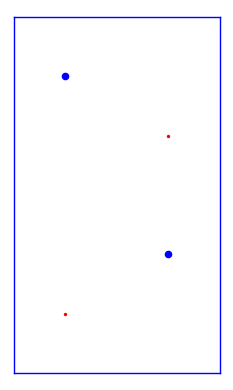

In [10]:
p = model4.plot()
model4.show(p)

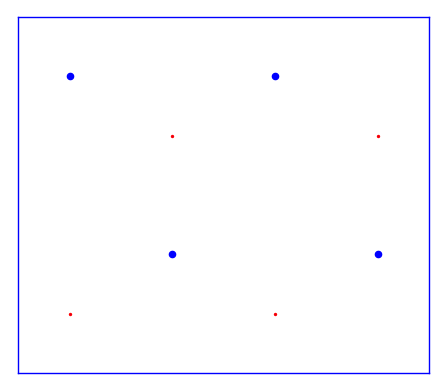

In [11]:
p = model8.plot()
model8.show(p)

In [12]:
model4.ComputeForce(use_dxdy=False, use_d0 = True)
disp(model4.PotentialEnergy())

<IPython.core.display.Math object>

In [13]:
model4.ComputeForce(use_dxdy=False)
disp(model4.PotentialEnergy())

<IPython.core.display.Math object>

In [14]:
model4.ComputeForce(use_dxdy=True)
U = model4.PotentialEnergy()
disp(U)

<IPython.core.display.Math object>

In [15]:
Ut2 = model4.PotentialEnergyTaylor(2)
disp(Ut2)

<IPython.core.display.Math object>

In [16]:
disp(model4.KineticEnergy())

<IPython.core.display.Math object>

In [17]:
disp(model4.Lagrangian())

<IPython.core.display.Math object>

In [18]:
disp(model4.LagrangianTaylor(2))

<IPython.core.display.Math object>

обобщенные импульсы

$P = \frac{\partial L}{\partial \dot{x}} = \frac{\partial L}{\partial {v}}$

In [19]:
Px, Py = model4.Momentum()
disp(Px)
disp(Py)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [20]:
px, py = model4.momentum()
disp(px)
disp(py)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Запишем уравнения Эйлера-Лагранжа

$\frac{d}{dt}\frac{\partial L}{\partial \dot{x}} - \frac{\partial L}{\partial {x}} = 0$

In [21]:
eqs_x, eqs_y = model4.EulerLagrange(2)

In [22]:
for eq_x in eqs_x:
    disp(eq_x)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [23]:
for eq_y in eqs_y:
    disp(eq_y)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [24]:
eqsi_x, eqsi_y, Ax, Ay, Amx, Amy = model4.EulerLagrangeSolution(2)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [25]:
Matrix = GenerateMatrix(eqsi_x + eqsi_y, Ax + Ay)
disp(Matrix)

<IPython.core.display.Math object>

In [26]:
Matrix = GenerateMatrix(eqsi_x + eqsi_y, Amx + Amy)
disp(Matrix)

<IPython.core.display.Math object>

In [28]:
det_M = Matrix.det()
det_M.factor()

1/4*(2*M^2*m^2*omega^4 - 6*M^2*k*m*omega^2 - 6*M*k*m^2*omega^2 + 3*M^2*k^2 + 10*M*k^2*m + 3*k^2*m^2)*(2*M^2*m^2*omega^4 - 6*M^2*k*m*omega^2 - 6*M*k*m^2*omega^2 + 3*M^2*k^2 + 6*M*k^2*m + 3*k^2*m^2)*omega^8

In [29]:
sol_omega = solve(det_M == 0, omega)
for sol_omega_i in sol_omega:
    disp(sol_omega_i)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [30]:
for sol_omega_i in sol_omega:
    disp(sol_omega_i.subs(values))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

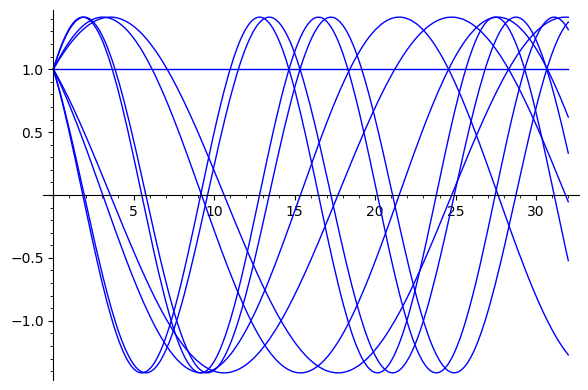

In [31]:
p = Graphics()
for sol_omega_i in sol_omega:
    p += plot((cos(omega*t)+sin(omega*t)).subs(sol_omega_i.subs(values)), t, 0, 32)
p.show()

обобщенные импульсы

$P = \frac{\partial L}{\partial \dot{x}} = \frac{\partial L}{\partial {v}}$

In [32]:
des0, f0, dvars = model8.numeric_des(n=0)

In [34]:
des2, f2, dvars = model8.numeric_des(n=2)

In [35]:
des3, f3, dvars = model8.numeric_des(n=3)

In [40]:
# инициализация начальных условий

y0 = +0.001
#y0 = -0.01

ics=[0 for i in range(4*model8.atom_count)]
ics[2*model8.atom_count-3] = y0
#ics[2*model8.atom_count-1] = y0
for i in range(4*model8.atom_count):
    print(dvars[i], "(0) = ", ics[i])

dx_0 (0) =  0
dy_0 (0) =  0
dx_1 (0) =  0
dy_1 (0) =  0
dx_2 (0) =  0
dy_2 (0) =  0
dx_3 (0) =  0
dy_3 (0) =  0
dx_4 (0) =  0
dy_4 (0) =  0
dx_5 (0) =  0
dy_5 (0) =  0
dx_6 (0) =  0
dy_6 (0) =  0.00100000000000000
dx_7 (0) =  0
dy_7 (0) =  0
vx_0 (0) =  0
vy_0 (0) =  0
vx_1 (0) =  0
vy_1 (0) =  0
vx_2 (0) =  0
vy_2 (0) =  0
vx_3 (0) =  0
vy_3 (0) =  0
vx_4 (0) =  0
vy_4 (0) =  0
vx_5 (0) =  0
vy_5 (0) =  0
vx_6 (0) =  0
vy_6 (0) =  0
vx_7 (0) =  0
vy_7 (0) =  0


In [41]:
dt = 0.01
times = srange(0, 20000, dt)

In [42]:
# Solve numerically a system of first-order ordinary differential equations
# using odeint from scipy.integrate module.

# des – right hand sides of the system
# ics – initial conditions
# times – a sequence of time points in which the solution must be found
# dvars – dependent variables. ATTENTION: the order must be the same as in des, that means: d(dvars[i])/dt=des[i]
# ivar – independent variable, optional.

sol0 = desolve_odeint(des=f0, ics=ics, times=times, dvars=dvars, ivar=t)
sol2 = desolve_odeint(des=f2, ics=ics, times=times, dvars=dvars, ivar=t)
sol3 = desolve_odeint(des=f3, ics=ics, times=times, dvars=dvars, ivar=t)

/usr3/articles/sagemath_docker_build/sage/local/lib/python3.10/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [43]:
colors = ["red", "green", "yellow", "blue", "pink", "brown", "aqua", "grey"]

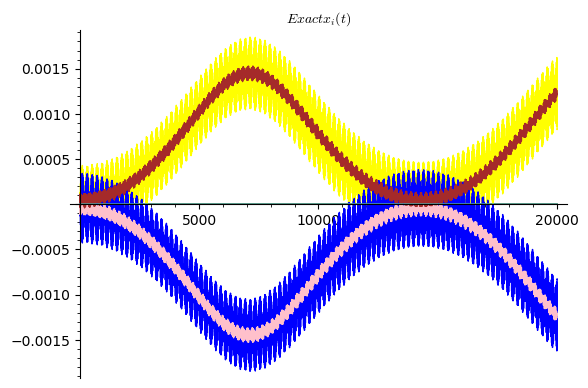

In [44]:
p = Graphics()
for i in range(model8.atom_count):
    p += line(zip(times, sol0[:,2*i]), color=colors[i])
p.show(title="$Exact x_i(t)$")

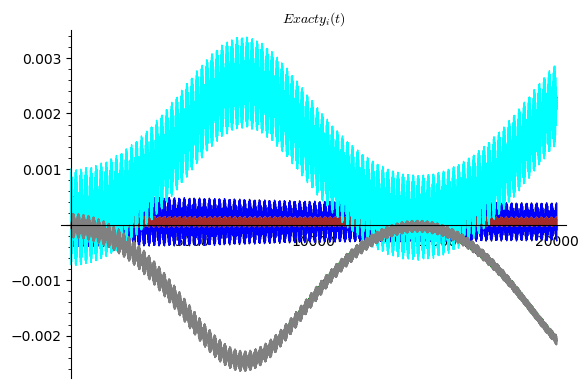

In [45]:
p = Graphics()
for i in range(model8.atom_count):
    p += line(zip(times, sol0[:,2*i+1]), color=colors[i])
p.show(title="$Exact y_i(t)$")

In [46]:
max_points=[[] for i in range(4*model8.atom_count)]
for iatom in range(4*model8.atom_count):
    for itime in range(len(sol0) - 2):
        if  sol0[itime, iatom] < sol0[itime + 1, iatom] \
        and sol0[itime + 1, iatom] > sol0[itime + 2, iatom]:
            max_points[iatom] += [itime + 1]

In [48]:
for sol_omega_i in sol_omega:
    try:
        print((2*pi/sol_omega_i.rhs()).subs(values).n())
    except:
        print((sol_omega_i.rhs()).subs(values))

-14.6447805965425
14.6447805965425
-28.2915435970748
28.2915435970748
-15.3313253234464
15.3313253234464
-24.5617920808184
24.5617920808184
0


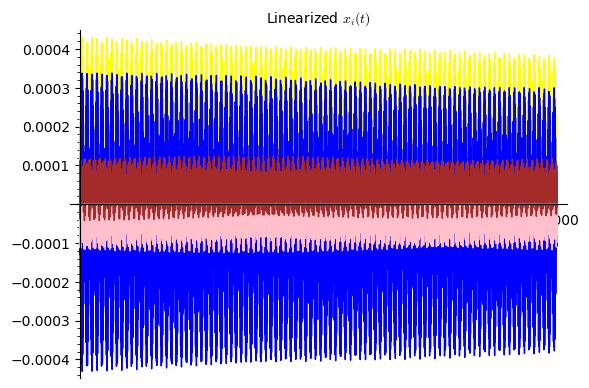

In [49]:
p = Graphics()
for i in range(model8.atom_count):
    p += line(zip(times, sol2[:,2*i]), color=colors[i])
p.show(title="Linearized $x_i(t)$")

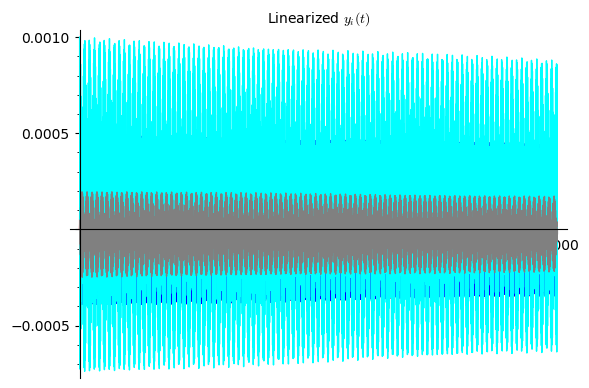

In [50]:
p = Graphics()
for i in range(model8.atom_count):
    p += line(zip(times, sol2[:,2*i+1]), color=colors[i])
p.show(title="Linearized $y_i(t)$")

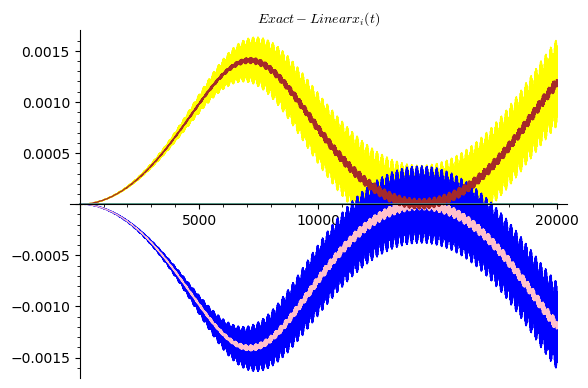

In [51]:
p = Graphics()
for i in range(model8.atom_count):
    p += line(zip(times, sol0[:,2*i]-sol2[:,2*i]), color=colors[i])
p.show(title="$Exact-Linear x_i(t)$")

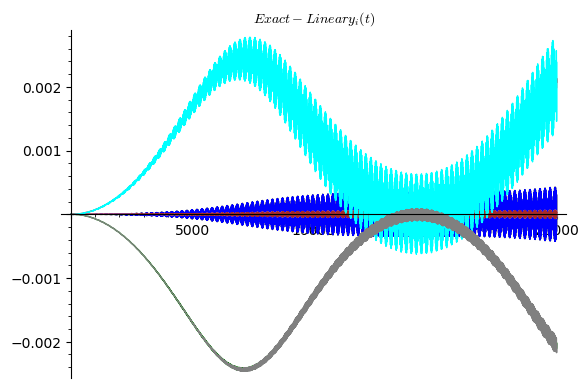

In [52]:
p = Graphics()
for i in range(model8.atom_count):
    p += line(zip(times, sol0[:,2*i+1]-sol2[:,2*i+1]), color=colors[i])
p.show(title="$Exact-Linear y_i(t)$")

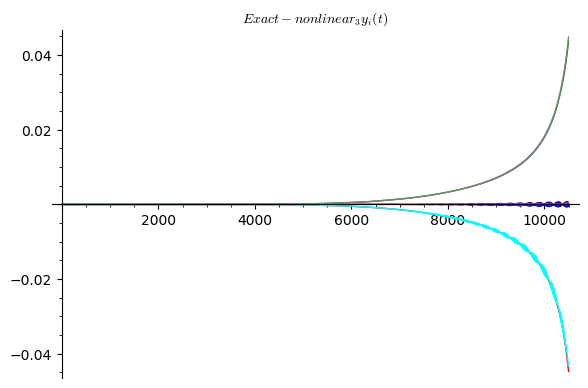

In [53]:
M = 1050000

p = Graphics()
for i in range(model8.atom_count):
    p += line(zip(times,sol0[0:M,2*i+1]-sol3[0:M,2*i+1]), color=colors[i])
p.show(title="$Exact - nonlinear_3 y_i(t)$")

In [ ]:
p = Graphics()
for i in range(model8.atom_count):
    p += line(zip(times,sol3[0:M,2*i+2*model8.atom_count]-sol2[0:M,2*i+2*model8.atom_count]), color=colors[i])
p.show(title="$\\dot{x_i}(t)$")

In [ ]:
p = Graphics()
for i in range(model8.atom_count):
    p += line(zip(times,sol3[0:M,2*i+1+2*model8.atom_count]-sol2[0:M,2*i+1+2*model8.atom_count]), color=colors[i])
p.show(title="$\\dot{y_i}(t)$")

Animation with 2000 frames
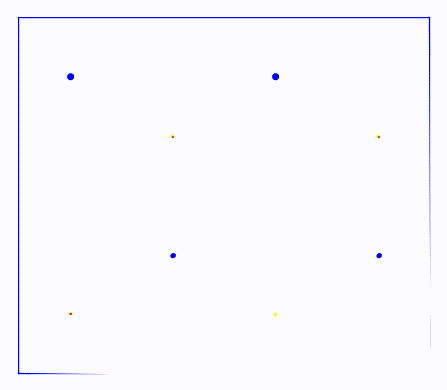

In [57]:
model8.animate_sol(times, sol0, 1000)

Animation with 2000 frames
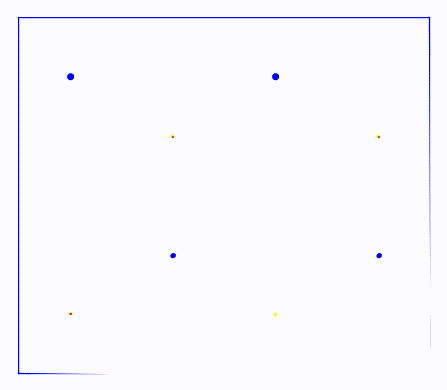

In [58]:
model8.animate_sol(times, sol2, 1000)

Animation with 2000 frames
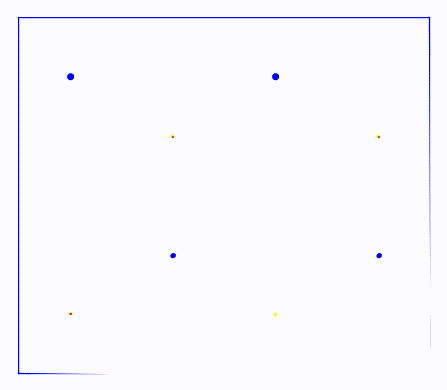

In [59]:
model8.animate_sol(times, sol3, 1000)

We have the following linearized Euler Lagrange equations:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Using exponent-like solutions we have the following algebraic system:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Matrix of this system is:


<IPython.core.display.Math object>

determinant is:


<IPython.core.display.Math object>

we have solution when the determinant is 0


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

using the following found frequency


<IPython.core.display.Math object>

we have the following system for amplitude coefficients


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

with determinant:


<IPython.core.display.Math object>

rank of this system is:


<IPython.core.display.Math object>

so I can eleminate 8  -  7  =  1 equations


<IPython.core.display.Math object>

<IPython.core.display.Math object>

And the solution for frequency omega == -sqrt(3/2*k/M + 3/2*k/m + 1/2*sqrt(3*M^2 - 2*M*m + 3*m^2)*k/(M*m)) is:


<IPython.core.display.Math object>

assuming that M is  0.0400000000000000  we have:
assuming that r1 is  0.0400000000000000  we have:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

and the mode motion is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

assumed M=0.0400000000000000 r1=0.0400000000000000 mode motion is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

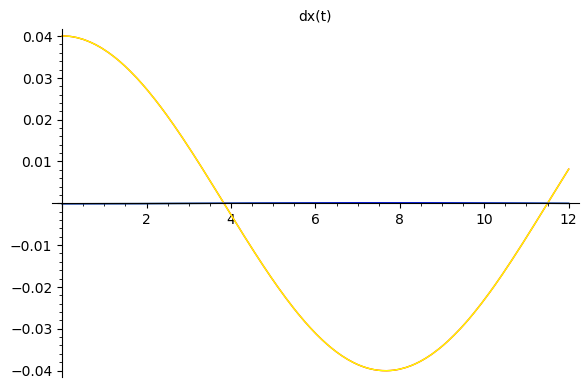

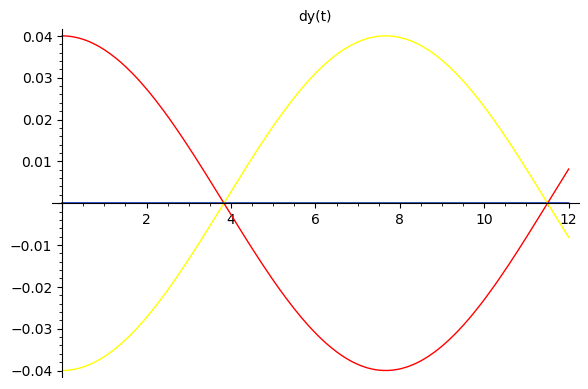

Animation with 120 frames
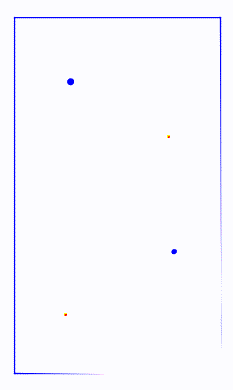

using the following found frequency


<IPython.core.display.Math object>

we have the following system for amplitude coefficients


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

with determinant:


<IPython.core.display.Math object>

rank of this system is:


<IPython.core.display.Math object>

so I can eleminate 8  -  7  =  1 equations


<IPython.core.display.Math object>

<IPython.core.display.Math object>

And the solution for frequency omega == sqrt(3/2*k/M + 3/2*k/m + 1/2*sqrt(3*M^2 - 2*M*m + 3*m^2)*k/(M*m)) is:


<IPython.core.display.Math object>

assuming that M is  0.0400000000000000  we have:
assuming that r2 is  0.0400000000000000  we have:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

and the mode motion is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

assumed M=0.0400000000000000 r2=0.0400000000000000 mode motion is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

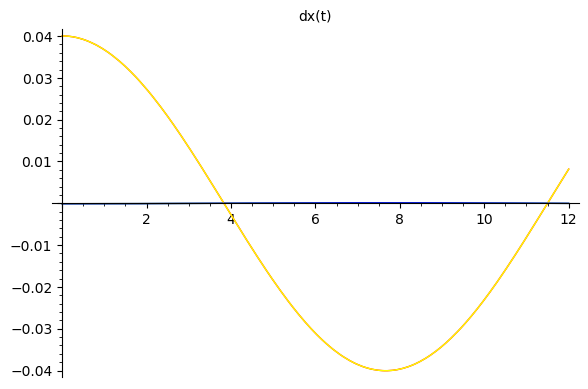

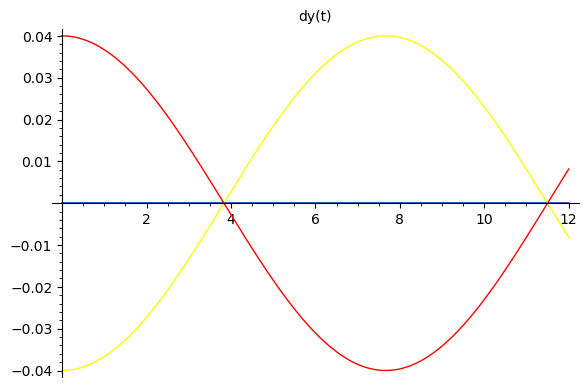

Animation with 120 frames
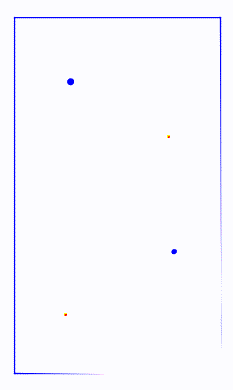

using the following found frequency


<IPython.core.display.Math object>

we have the following system for amplitude coefficients


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

with determinant:


<IPython.core.display.Math object>

rank of this system is:


<IPython.core.display.Math object>

so I can eleminate 8  -  7  =  1 equations


<IPython.core.display.Math object>

<IPython.core.display.Math object>

And the solution for frequency omega == -sqrt(3/2*k/M + 3/2*k/m - 1/2*sqrt(3*M^2 - 2*M*m + 3*m^2)*k/(M*m)) is:


<IPython.core.display.Math object>

assuming that M is  0.0400000000000000  we have:
assuming that r3 is  0.0400000000000000  we have:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

and the mode motion is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

assumed M=0.0400000000000000 r3=0.0400000000000000 mode motion is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

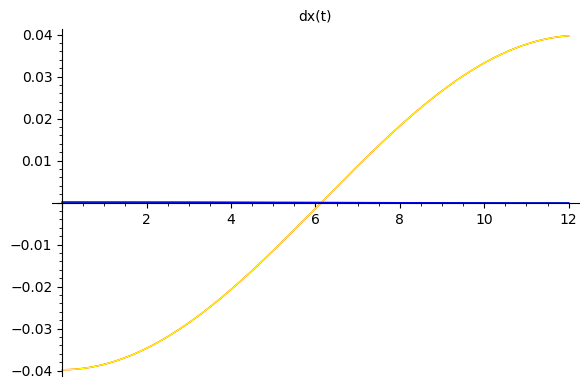

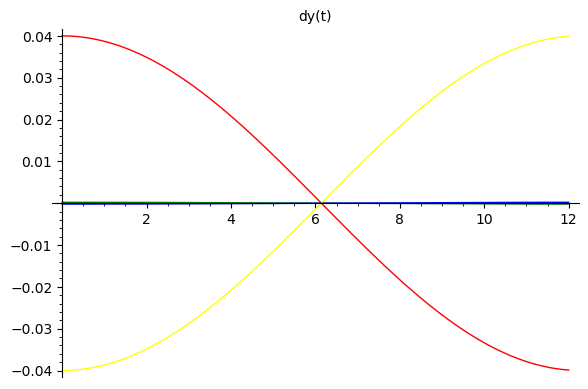

Animation with 120 frames
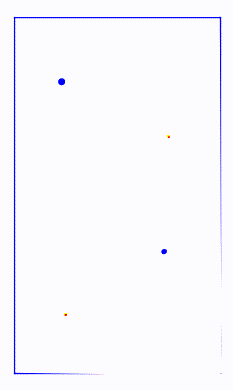

using the following found frequency


<IPython.core.display.Math object>

we have the following system for amplitude coefficients


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

with determinant:


<IPython.core.display.Math object>

rank of this system is:


<IPython.core.display.Math object>

so I can eleminate 8  -  7  =  1 equations


<IPython.core.display.Math object>

<IPython.core.display.Math object>

And the solution for frequency omega == sqrt(3/2*k/M + 3/2*k/m - 1/2*sqrt(3*M^2 - 2*M*m + 3*m^2)*k/(M*m)) is:


<IPython.core.display.Math object>

assuming that M is  0.0400000000000000  we have:
assuming that r4 is  0.0400000000000000  we have:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

and the mode motion is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

assumed M=0.0400000000000000 r4=0.0400000000000000 mode motion is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

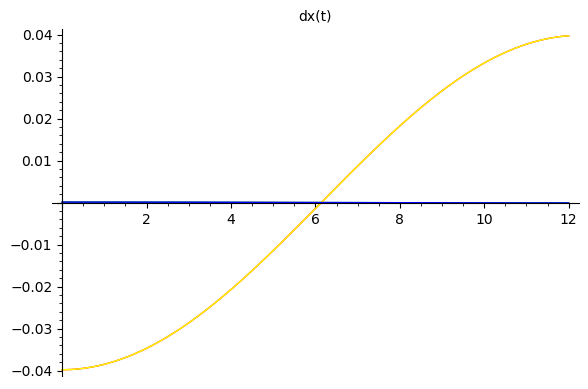

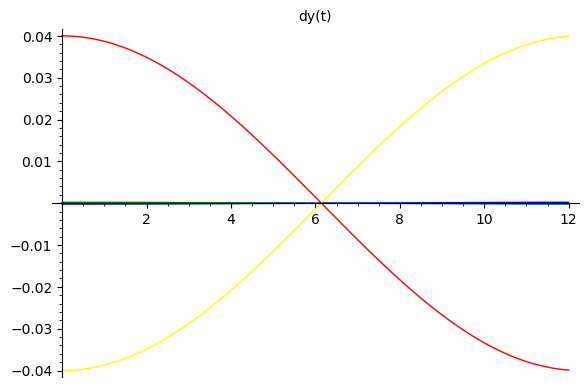

Animation with 120 frames
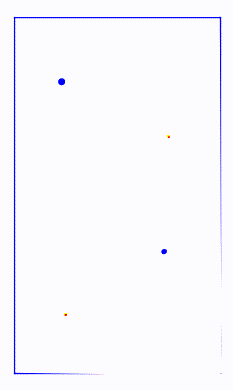

using the following found frequency


<IPython.core.display.Math object>

we have the following system for amplitude coefficients


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

with determinant:


<IPython.core.display.Math object>

rank of this system is:


<IPython.core.display.Math object>

so I can eleminate 8  -  7  =  1 equations


<IPython.core.display.Math object>

<IPython.core.display.Math object>

And the solution for frequency omega == -sqrt(1/2*sqrt(3)*k/M + 1/2*sqrt(3)*k/m + 3/2*k/M + 3/2*k/m) is:


<IPython.core.display.Math object>

assuming that r5 is  0.0400000000000000  we have:
assuming that M is  0.0400000000000000  we have:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

and the mode motion is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

assumed r5=0.0400000000000000 M=0.0400000000000000 mode motion is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

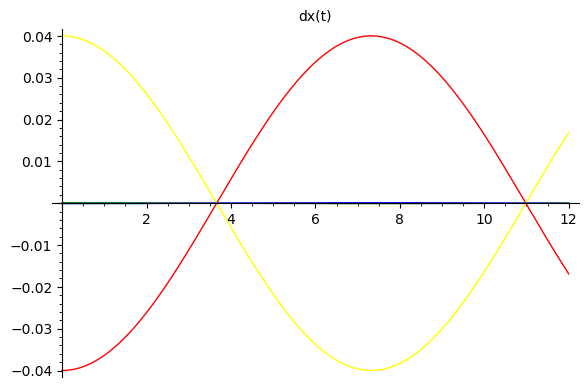

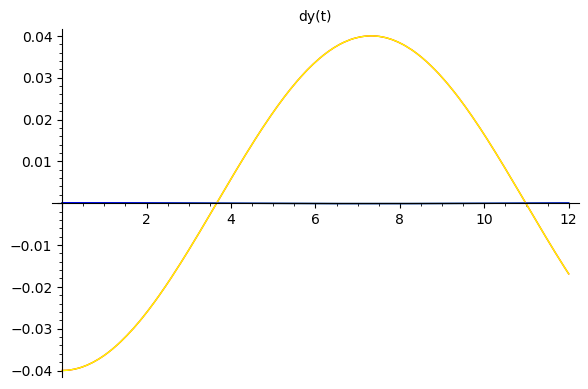

Animation with 120 frames
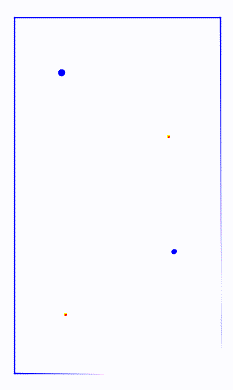

using the following found frequency


<IPython.core.display.Math object>

we have the following system for amplitude coefficients


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

with determinant:


<IPython.core.display.Math object>

rank of this system is:


<IPython.core.display.Math object>

so I can eleminate 8  -  7  =  1 equations


<IPython.core.display.Math object>

<IPython.core.display.Math object>

And the solution for frequency omega == sqrt(1/2*sqrt(3)*k/M + 1/2*sqrt(3)*k/m + 3/2*k/M + 3/2*k/m) is:


<IPython.core.display.Math object>

assuming that r6 is  0.0400000000000000  we have:
assuming that M is  0.0400000000000000  we have:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

and the mode motion is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

assumed r6=0.0400000000000000 M=0.0400000000000000 mode motion is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

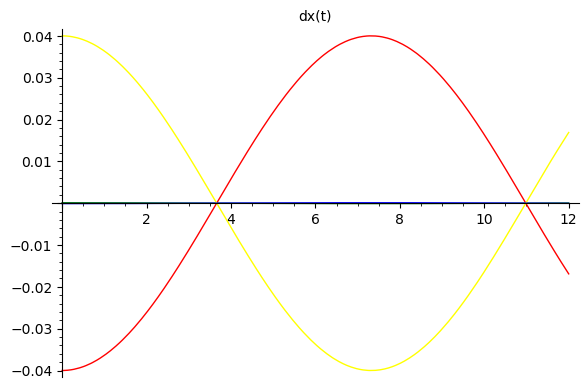

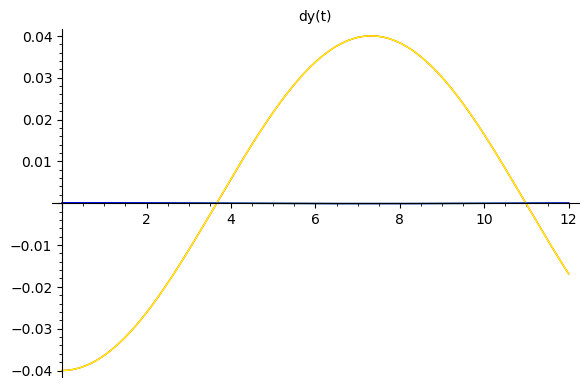

Animation with 120 frames
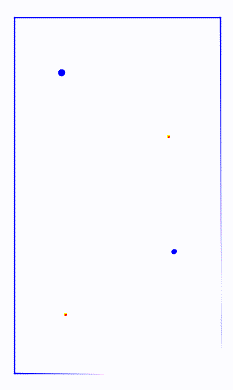

using the following found frequency


<IPython.core.display.Math object>

we have the following system for amplitude coefficients


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

with determinant:


<IPython.core.display.Math object>

rank of this system is:


<IPython.core.display.Math object>

so I can eleminate 8  -  7  =  1 equations


<IPython.core.display.Math object>

<IPython.core.display.Math object>

And the solution for frequency omega == -sqrt(-1/2*sqrt(3)*k/M - 1/2*sqrt(3)*k/m + 3/2*k/M + 3/2*k/m) is:


<IPython.core.display.Math object>

assuming that r7 is  0.0400000000000000  we have:
assuming that M is  0.0400000000000000  we have:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

and the mode motion is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

assumed r7=0.0400000000000000 M=0.0400000000000000 mode motion is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

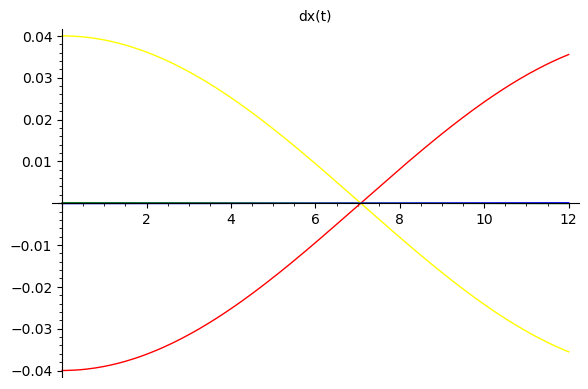

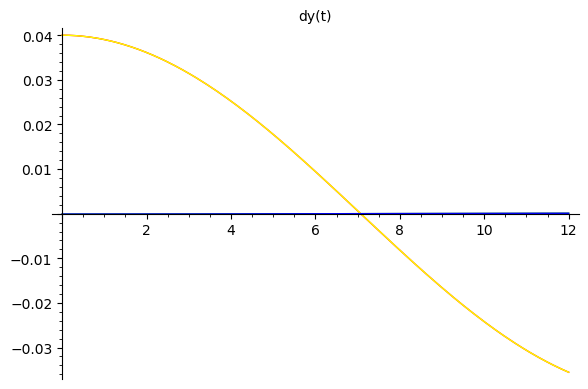

Animation with 120 frames
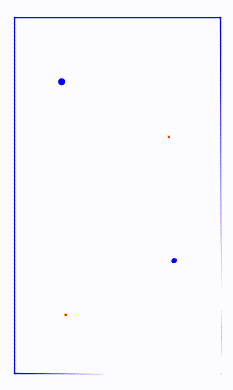

using the following found frequency


<IPython.core.display.Math object>

we have the following system for amplitude coefficients


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

with determinant:


<IPython.core.display.Math object>

rank of this system is:


<IPython.core.display.Math object>

so I can eleminate 8  -  7  =  1 equations


<IPython.core.display.Math object>

<IPython.core.display.Math object>

And the solution for frequency omega == sqrt(-1/2*sqrt(3)*k/M - 1/2*sqrt(3)*k/m + 3/2*k/M + 3/2*k/m) is:


<IPython.core.display.Math object>

assuming that r8 is  0.0400000000000000  we have:
assuming that M is  0.0400000000000000  we have:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

and the mode motion is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

assumed r8=0.0400000000000000 M=0.0400000000000000 mode motion is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

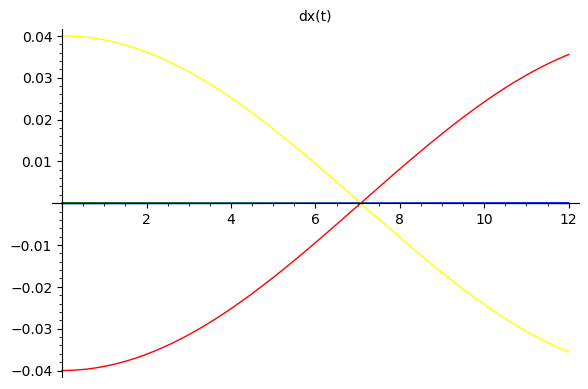

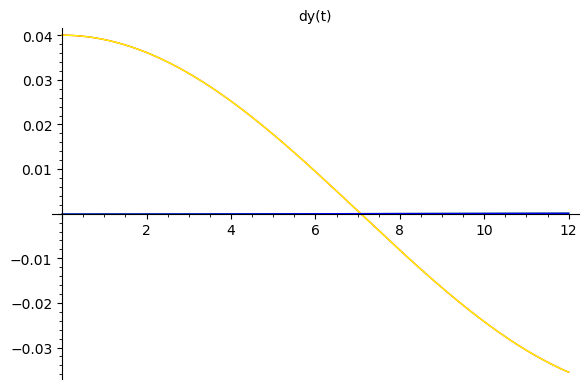

Animation with 120 frames
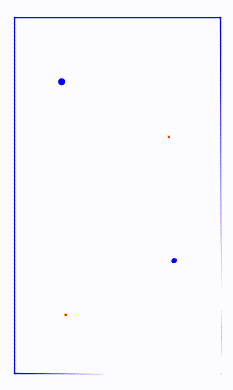

using the following found frequency


<IPython.core.display.Math object>

we have the following system for amplitude coefficients


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

with determinant:


<IPython.core.display.Math object>

rank of this system is:


<IPython.core.display.Math object>

so I can eleminate 8  -  4  =  4 equations


<IPython.core.display.Math object>

<IPython.core.display.Math object>

And the solution for frequency omega == 0 is:


<IPython.core.display.Math object>

assuming that r11 is  0.0400000000000000  we have:
assuming that r12 is  0.0400000000000000  we have:
assuming that r14 is  0.0400000000000000  we have:
assuming that r10 is  0.0400000000000000  we have:
assuming that r13 is  0.0400000000000000  we have:
assuming that r9 is  0.0400000000000000  we have:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

and the mode motion is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

assumed r11=0.0400000000000000 r12=0.0400000000000000 r14=0.0400000000000000 r10=0.0400000000000000 r13=0.0400000000000000 r9=0.0400000000000000 mode motion is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

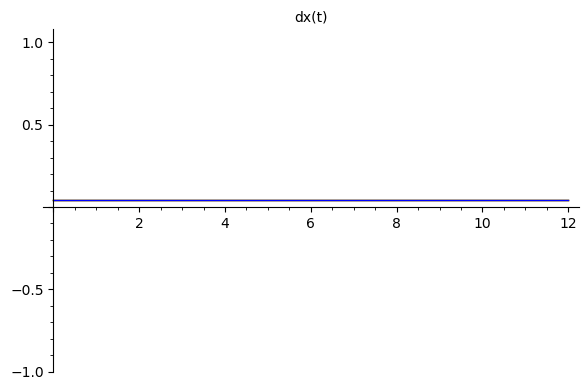

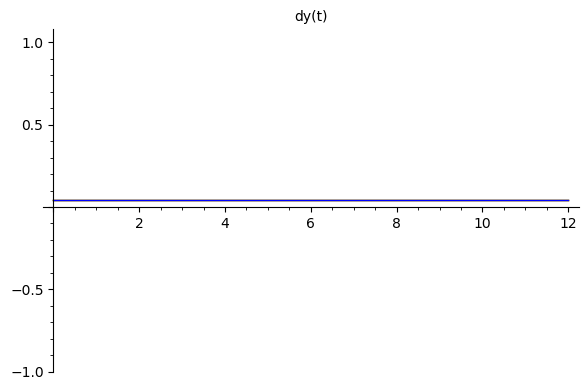

Animation with 120 frames
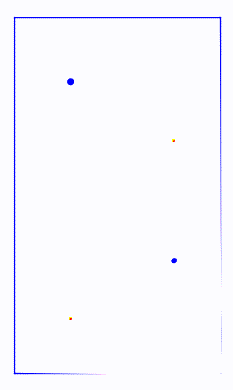

In [60]:
mode_motions, assumed_mode_motions = model4.EulerLagrangeMatrix()

In [86]:
def successive_approximations(model):
    # linear
    # система уравнений Эйлера-Лагранжа
    eqs_x, eqs_y = model.EulerLagrange(n = 2)
    print("linear Euler Lagrange equation's part")
    #disp(eqs_x + eqs_y)
    for i in range(model.atom_count):
        linear_eq_x = (eqs_x)[i]
        linear_eq_y = (eqs_y)[i]
        print("linear_eq_x", i)
        disp(linear_eq_x)
        print("linear_eq_y", i)
        disp(linear_eq_y)

    # nonlinear part of potential energy
    nonlinear_part_of_U = model.PotentialEnergyTaylor(n = 3)[2:][0]

    print("nonlinear Euler Lagrange equation's part")
    # nonlinear система уравнений Эйлера-Лагранжа
    nonlinear_dUdx = []
    nonlinear_dUdy = []

    for i in range(model.atom_count):
        nonlinear_dUdx += [ nonlinear_part_of_U \
                            .subs(model.dx[i] == model.DX[i]) \
                            .diff(model.DX[i]) \
                            .subs(model.DX[i] == model.dx[i]) ]
        nonlinear_dUdy += [ nonlinear_part_of_U \
                            .subs(model.dy[i] == model.DY[i]) \
                            .diff(model.DY[i]) \
                            .subs(model.DY[i] == model.dy[i]) ]

        print("nonlinear dUdx", i)
        disp(nonlinear_dUdx[i])
        print("nonlinear dUdy", i)
        disp(nonlinear_dUdy[i])

    # решение системы уравнений Эйлера-Лагранжа
    # ищем в виде

    # нулевое приближение удобнее выбрать
    # в виде exp от I*omega_0*t
    # с неким сдвигом фаз phi
    # и со сдвигом частоты omega_1

    xi = []
    yi = []

    for i in range(model.atom_count):
        # e^(i*omega*t)
        xi += [model.Ax[i]*exp(I*omega*t)]
        yi += [model.Ay[i]*exp(I*omega*t)]

    # подставляя решения в систему
    # уравнений Эйлера Лагранжа
    # получаем систему линейных алгебраичных уравнений

    # метод последовательных приближений
    # вводим добавку x1 к нулевому приближению решения,
    # и подставляем это решение
    # с добавкой лишь к линейной части дифференциального уравнения
    # но в нелинейной части пока что пренебегаем добавкой x1
    # предположив малость величины добавки x1 по сравнению с x0

    print("method of successive approximations")

    eqsi_x1 = []
    eqsi_y1 = []
    for i in range(model.atom_count):
        eqx_i = eqs_x[i].substitute_function(model.dx[i] == xi[i] + model.x1[i]).lhs() \
              - nonlinear_dUdx[i].substitute_function(model.dx[i] == xi[i])
        eqy_i = eqs_y[i].substitute_function(model.dy[i] == yi[i] + model.y1[i]).lhs() \
              - nonlinear_dUdy[i].substitute_function(model.dy[i] == yi[i])
        for j in range(model.atom_count):
            eqx_i = eqx_i.subs(model.dx[j] == xi[j] + model.x1[i])
            eqx_i = eqx_i.subs(model.dy[j] == yi[j] + model.y1[i])

            eqy_i = eqy_i.subs(model.dx[j] == xi[j] + model.x1[i])
            eqy_i = eqy_i.subs(model.dy[j] == yi[j] + model.y1[i])

        eqx_i = eqx_i.expand().collect(model.x1[i])
        eqy_i = eqy_i.expand().collect(model.y1[i])

        print("eqx_i",i)
        disp(eqx_i)
        print("eqy_i",i)
        disp(eqy_i)

        print("coefficient on", model.x1[i])
        x1_coeff_t = eqx_i.coefficient(model.x1[i])
        disp(x1_coeff_t)

        x1_coeff = (x1_coeff_t / exp(I*omega*t)).expand()
        disp(x1_coeff)

        C_x1 = var("C_x1")

        print("coefficient on", model.x1[i].diff(t))
        dx1dt_coeff = eqx_i.coefficient(model.x1[i].diff(t))
        disp(dx1dt_coeff)

        print("coefficient on", model.x1[i].diff(t, 2))
        d2x1dt2_coeff = eqx_i.coefficient(model.x1[i].diff(t, 2))
        disp(d2x1dt2_coeff)

        print("coefficient on", model.x1[i]^2)
        x1_2_coeff = eqx_i.coefficient(model.x1[i]^2)
        disp(x1_2_coeff)

        # однородная часть дифференциального уравнения
        uniform_x = d2x1dt2_coeff * model.x1[i].diff(t, 2) + \
                    dx1dt_coeff * model.x1[i].diff(t) + \
                    x1_coeff * model.x1[i] * exp(I*omega*t)

        uniform_Cx = d2x1dt2_coeff * model.x1[i].diff(t, 2) + \
                    dx1dt_coeff * model.x1[i].diff(t) + \
                    C_x1 * model.x1[i] * exp(I*omega*t)

        # слагаемые типа "вынуждающей силы"
        f_x = (eqx_i - uniform_x - x1_2_coeff * model.x1[i]^2).expand()
        print("f_x")
        disp(f_x)

        # отбрасываем слагаемое с model.x1[i]^2 имеющее больший порядок малости
        other_x = eqx_i - x1_2_coeff * model.x1[i]^2

        print("coefficient on", model.y1[i])
        y1_coeff_t = eqy_i.coefficient(model.y1[i])
        disp(y1_coeff_t)

        y1_coeff = (y1_coeff_t / exp(I*omega*t)).expand()
        disp(y1_coeff)

        C_y1 = var("C_y1")

        print("coefficient on", model.y1[i].diff(t))
        dy1dt_coeff = eqy_i.coefficient(model.y1[i].diff(t))
        disp(dy1dt_coeff)

        print("coefficient on", model.y1[i].diff(t, 2))
        d2y1dt2_coeff = eqy_i.coefficient(model.y1[i].diff(t, 2))
        disp(d2y1dt2_coeff)

        print("coefficient on", model.y1[i]^2)
        y1_2_coeff = eqy_i.coefficient(model.y1[i]^2)
        disp(y1_2_coeff)

        # однородная часть дифференциального уравнения
        uniform_y = d2y1dt2_coeff * model.y1[i].diff(t, 2) + \
                    dy1dt_coeff * model.y1[i].diff(t) + \
                    y1_coeff * model.y1[i] * exp(I*omega*t)

        uniform_Cy = d2y1dt2_coeff * model.y1[i].diff(t, 2) + \
                    dy1dt_coeff * model.y1[i].diff(t) + \
                    C_y1 * model.y1[i] * exp(I*omega*t)

        # слагаемые типа "вынуждающей силы"
        f_y = (eqy_i - uniform_y - y1_2_coeff * model.y1[i]^2).expand()
        print("f_y")
        disp(f_y)

        # отбрасываем слагаемое с model.x1[i]^2 имеющее больший порядок малости
        other_y = eqy_i - y1_2_coeff * model.y1[i]^2

        eqsi_x1 += [ other_x == 0]
        eqsi_y1 += [ other_y == 0]    

        print("eqsi_x1[", i, "]")
        disp(eqsi_x1[i])
        print("eqsi_y1[", i, "]")
        disp(eqsi_y1[i])

        # решаем однородное дифференциальное уравнение относительно x1
        #print("uniform solve with x1")
        #disp(uniform_Cx == 0)
        #uniform_sol_x1 = desolve(uniform_Cx == 0, model.x1[i], ivar=t, algorithm="fricas")
        #print(uniform_sol_x1)

        # решаем однородное дифференциальное уравнение относительно y1
        #print("uniform solve with y1")
        #disp(uniform_Cy == 0)
        #uniform_sol_y1 = desolve(uniform_Cy == 0, model.y1[i], ivar=t, contrib_ode = True)
        #print(uniform_sol_y1)

        # решаем это дифференциальное уравнение относительно x1
        #print("solve with x1")
        #disp(eqsi_x[i])
        #sol_x1 = desolve(eqsi_x[i], model.x1[i], ivar=t, contrib_ode = True)
        #print(sol_x1)

        # решаем это дифференциальное уравнение относительно y1
        #print("solve with y1")
        #disp(eqsi_y[i])
        #sol_y1 = desolve(eqsi_y[i], model.y1[i], ivar=t, contrib_ode = True)
        #print(sol_y1)

    return eqsi_x1, eqsi_y1

In [87]:
eqsi_x1, eqsi_y1 = successive_approximations(model4)

linear Euler Lagrange equation's part
linear_eq_x 0


<IPython.core.display.Math object>

linear_eq_y 0


<IPython.core.display.Math object>

linear_eq_x 1


<IPython.core.display.Math object>

linear_eq_y 1


<IPython.core.display.Math object>

linear_eq_x 2


<IPython.core.display.Math object>

linear_eq_y 2


<IPython.core.display.Math object>

linear_eq_x 3


<IPython.core.display.Math object>

linear_eq_y 3


<IPython.core.display.Math object>

nonlinear Euler Lagrange equation's part
nonlinear dUdx 0


<IPython.core.display.Math object>

nonlinear dUdy 0


<IPython.core.display.Math object>

nonlinear dUdx 1


<IPython.core.display.Math object>

nonlinear dUdy 1


<IPython.core.display.Math object>

nonlinear dUdx 2


<IPython.core.display.Math object>

nonlinear dUdy 2


<IPython.core.display.Math object>

nonlinear dUdx 3


<IPython.core.display.Math object>

nonlinear dUdy 3


<IPython.core.display.Math object>

method of successive approximations
eqx_i 0


<IPython.core.display.Math object>

eqy_i 0


<IPython.core.display.Math object>

coefficient on x1_0(t)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

coefficient on diff(x1_0(t), t)


<IPython.core.display.Math object>

coefficient on diff(x1_0(t), t, t)


<IPython.core.display.Math object>

coefficient on x1_0(t)^2


<IPython.core.display.Math object>

f_x


<IPython.core.display.Math object>

coefficient on y1_0(t)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

coefficient on diff(y1_0(t), t)


<IPython.core.display.Math object>

coefficient on diff(y1_0(t), t, t)


<IPython.core.display.Math object>

coefficient on y1_0(t)^2


<IPython.core.display.Math object>

f_y


<IPython.core.display.Math object>

eqsi_x1[ 0 ]


<IPython.core.display.Math object>

eqsi_y1[ 0 ]


<IPython.core.display.Math object>

eqx_i 1


<IPython.core.display.Math object>

eqy_i 1


<IPython.core.display.Math object>

coefficient on x1_1(t)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

coefficient on diff(x1_1(t), t)


<IPython.core.display.Math object>

coefficient on diff(x1_1(t), t, t)


<IPython.core.display.Math object>

coefficient on x1_1(t)^2


<IPython.core.display.Math object>

f_x


<IPython.core.display.Math object>

coefficient on y1_1(t)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

coefficient on diff(y1_1(t), t)


<IPython.core.display.Math object>

coefficient on diff(y1_1(t), t, t)


<IPython.core.display.Math object>

coefficient on y1_1(t)^2


<IPython.core.display.Math object>

f_y


<IPython.core.display.Math object>

eqsi_x1[ 1 ]


<IPython.core.display.Math object>

eqsi_y1[ 1 ]


<IPython.core.display.Math object>

eqx_i 2


<IPython.core.display.Math object>

eqy_i 2


<IPython.core.display.Math object>

coefficient on x1_2(t)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

coefficient on diff(x1_2(t), t)


<IPython.core.display.Math object>

coefficient on diff(x1_2(t), t, t)


<IPython.core.display.Math object>

coefficient on x1_2(t)^2


<IPython.core.display.Math object>

f_x


<IPython.core.display.Math object>

coefficient on y1_2(t)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

coefficient on diff(y1_2(t), t)


<IPython.core.display.Math object>

coefficient on diff(y1_2(t), t, t)


<IPython.core.display.Math object>

coefficient on y1_2(t)^2


<IPython.core.display.Math object>

f_y


<IPython.core.display.Math object>

eqsi_x1[ 2 ]


<IPython.core.display.Math object>

eqsi_y1[ 2 ]


<IPython.core.display.Math object>

eqx_i 3


<IPython.core.display.Math object>

eqy_i 3


<IPython.core.display.Math object>

coefficient on x1_3(t)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

coefficient on diff(x1_3(t), t)


<IPython.core.display.Math object>

coefficient on diff(x1_3(t), t, t)


<IPython.core.display.Math object>

coefficient on x1_3(t)^2


<IPython.core.display.Math object>

f_x


<IPython.core.display.Math object>

coefficient on y1_3(t)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

coefficient on diff(y1_3(t), t)


<IPython.core.display.Math object>

coefficient on diff(y1_3(t), t, t)


<IPython.core.display.Math object>

coefficient on y1_3(t)^2


<IPython.core.display.Math object>

f_y


<IPython.core.display.Math object>

eqsi_x1[ 3 ]


<IPython.core.display.Math object>

eqsi_y1[ 3 ]


<IPython.core.display.Math object>

In [88]:
disp(eqsi_x1)

<IPython.core.display.Math object>

In [93]:
for mode_motion in mode_motions:
    sol_omega_i, sol_A, x_i_sol, y_i_sol, sol_A_independed_variables = mode_motion
    
    if sol_omega_i.rhs() == 0:
        continue

    print("sol_omega_i")
    disp(sol_omega_i)

    print("sol_A")
    disp(sol_A)

    print("sol_A_independed_variables")
    disp(sol_A_independed_variables)

    for i in range(model4.atom_count):
        eqsi_x1_A = (eqsi_x1[i].subs(sol_A)).expand()
        eqsi_y1_A = (eqsi_y1[i].subs(sol_A)).expand()

        print("eqsi_x1_A", i)
        print(eqsi_x1_A.variables())
        print("eqsi_y1_A", i)
        print(eqsi_y1_A.variables())

sol_omega_i


<IPython.core.display.Math object>

sol_A


<IPython.core.display.Math object>

sol_A_independed_variables


<IPython.core.display.Math object>

eqsi_x1_A 0
(M, k, l, m, omega, r1, t)
eqsi_y1_A 0
(M, k, l, m, omega, r1, t)
eqsi_x1_A 1
(M, k, l, m, omega, r1, t)
eqsi_y1_A 1
(M, k, l, m, omega, r1, t)
eqsi_x1_A 2
(M, k, l, m, omega, r1, t)
eqsi_y1_A 2
(M, k, l, m, omega, r1, t)
eqsi_x1_A 3
(M, k, l, m, omega, r1, t)
eqsi_y1_A 3
(M, k, l, m, omega, r1, t)
sol_omega_i


<IPython.core.display.Math object>

sol_A


<IPython.core.display.Math object>

sol_A_independed_variables


<IPython.core.display.Math object>

eqsi_x1_A 0
(M, k, l, m, omega, r2, t)
eqsi_y1_A 0
(M, k, l, m, omega, r2, t)
eqsi_x1_A 1
(M, k, l, m, omega, r2, t)
eqsi_y1_A 1
(M, k, l, m, omega, r2, t)
eqsi_x1_A 2
(M, k, l, m, omega, r2, t)
eqsi_y1_A 2
(M, k, l, m, omega, r2, t)
eqsi_x1_A 3
(M, k, l, m, omega, r2, t)
eqsi_y1_A 3
(M, k, l, m, omega, r2, t)
sol_omega_i


<IPython.core.display.Math object>

sol_A


<IPython.core.display.Math object>

sol_A_independed_variables


<IPython.core.display.Math object>

eqsi_x1_A 0
(M, k, l, m, omega, r3, t)
eqsi_y1_A 0
(M, k, l, m, omega, r3, t)
eqsi_x1_A 1
(M, k, l, m, omega, r3, t)
eqsi_y1_A 1
(M, k, l, m, omega, r3, t)
eqsi_x1_A 2
(M, k, l, m, omega, r3, t)
eqsi_y1_A 2
(M, k, l, m, omega, r3, t)
eqsi_x1_A 3
(M, k, l, m, omega, r3, t)
eqsi_y1_A 3
(M, k, l, m, omega, r3, t)
sol_omega_i


<IPython.core.display.Math object>

sol_A


<IPython.core.display.Math object>

sol_A_independed_variables


<IPython.core.display.Math object>

eqsi_x1_A 0
(M, k, l, m, omega, r4, t)
eqsi_y1_A 0
(M, k, l, m, omega, r4, t)
eqsi_x1_A 1
(M, k, l, m, omega, r4, t)
eqsi_y1_A 1
(M, k, l, m, omega, r4, t)
eqsi_x1_A 2
(M, k, l, m, omega, r4, t)
eqsi_y1_A 2
(M, k, l, m, omega, r4, t)
eqsi_x1_A 3
(M, k, l, m, omega, r4, t)
eqsi_y1_A 3
(M, k, l, m, omega, r4, t)
sol_omega_i


<IPython.core.display.Math object>

sol_A


<IPython.core.display.Math object>

sol_A_independed_variables


<IPython.core.display.Math object>

eqsi_x1_A 0
(M, k, l, m, omega, r5, t)
eqsi_y1_A 0
(M, k, l, m, omega, r5, t)
eqsi_x1_A 1
(M, k, l, m, omega, r5, t)
eqsi_y1_A 1
(M, k, l, m, omega, r5, t)
eqsi_x1_A 2
(M, k, l, m, omega, r5, t)
eqsi_y1_A 2
(M, k, l, m, omega, r5, t)
eqsi_x1_A 3
(M, k, l, m, omega, r5, t)
eqsi_y1_A 3
(M, k, l, m, omega, r5, t)
sol_omega_i


<IPython.core.display.Math object>

sol_A


<IPython.core.display.Math object>

sol_A_independed_variables


<IPython.core.display.Math object>

eqsi_x1_A 0
(M, k, l, m, omega, r6, t)
eqsi_y1_A 0
(M, k, l, m, omega, r6, t)
eqsi_x1_A 1
(M, k, l, m, omega, r6, t)
eqsi_y1_A 1
(M, k, l, m, omega, r6, t)
eqsi_x1_A 2
(M, k, l, m, omega, r6, t)
eqsi_y1_A 2
(M, k, l, m, omega, r6, t)
eqsi_x1_A 3
(M, k, l, m, omega, r6, t)
eqsi_y1_A 3
(M, k, l, m, omega, r6, t)
sol_omega_i


<IPython.core.display.Math object>

sol_A


<IPython.core.display.Math object>

sol_A_independed_variables


<IPython.core.display.Math object>

eqsi_x1_A 0
(M, k, l, m, omega, r7, t)
eqsi_y1_A 0
(M, k, l, m, omega, r7, t)
eqsi_x1_A 1
(M, k, l, m, omega, r7, t)
eqsi_y1_A 1
(M, k, l, m, omega, r7, t)
eqsi_x1_A 2
(M, k, l, m, omega, r7, t)
eqsi_y1_A 2
(M, k, l, m, omega, r7, t)
eqsi_x1_A 3
(M, k, l, m, omega, r7, t)
eqsi_y1_A 3
(M, k, l, m, omega, r7, t)
sol_omega_i


<IPython.core.display.Math object>

sol_A


<IPython.core.display.Math object>

sol_A_independed_variables


<IPython.core.display.Math object>

eqsi_x1_A 0
(M, k, l, m, omega, r8, t)
eqsi_y1_A 0
(M, k, l, m, omega, r8, t)
eqsi_x1_A 1
(M, k, l, m, omega, r8, t)
eqsi_y1_A 1
(M, k, l, m, omega, r8, t)
eqsi_x1_A 2
(M, k, l, m, omega, r8, t)
eqsi_y1_A 2
(M, k, l, m, omega, r8, t)
eqsi_x1_A 3
(M, k, l, m, omega, r8, t)
eqsi_y1_A 3
(M, k, l, m, omega, r8, t)


In [ ]:
for i in range(model.atom_count):
    print(i, model.crd0[i])

In [ ]:
for i in range(model.atom_count):
    print(i, model.nbr[i])

In [ ]:
for i in range(model.atom_count):
    print(i, model.nbr[i])
    for nb in model.nbr[i]:
        print(nb, model.nbr2index(nb))

In [ ]:
model.test_dUdX(2)

In [ ]:
disp(model.w[2])

In [ ]:
dw2dy2 = model.w[2].diff(model.DY[2])
disp(dw2dy2)

In [ ]:
for i in range(model.atom_count):
    model.test_UX(i)

In [ ]:
for i in range(model.atom_count):
    model.test_UY(i)

In [ ]:
model.test_UX(0)

In [ ]:
model.test_UY(0)

In [ ]:
model.test_dUdY(0)

In [ ]:
disp(model.w[0])